In [1]:
import torch
from decoder_SingleSessionSingleTrialDataset import SingleSessionSingleTrialDataset
import numpy as np
from pynwb import NWBHDF5IO

import os

dataset_path = "../000070"
nwb_file_path = os.path.join(
    dataset_path, "sub-Jenkins", "sub-Jenkins_ses-20090923_behavior+ecephys.nwb")
io = NWBHDF5IO(nwb_file_path, 'r')
nwb_file = io.read()
hand_data = nwb_file.processing['behavior'].data_interfaces['Position']['Hand'].data[:]
hand_timestamps = nwb_file.processing['behavior'].data_interfaces['Position']['Hand'].timestamps[:]
trial_data = nwb_file.intervals['trials']

unit_spike_times = [nwb_file.units[unit_id]['spike_times'].iloc[0][:]
                    for unit_id in range(len(nwb_file.units))]
n_neurons = len(unit_spike_times)
n_context_bins = 50 # was equal to 50 for the original demo

n_trials = 2000
datasets = [SingleSessionSingleTrialDataset(
    trial_data, hand_data, hand_timestamps, unit_spike_times, trial_id, bin_size=0.02, n_context_bins=n_context_bins) for trial_id in range(n_trials)]
dataset = torch.utils.data.ConcatDataset(datasets)
print(f"Dataset from {n_trials} trials has {len(dataset)} samples")

Dataset from 2000 trials has 198529 samples


In [2]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert dataset to PyTorch tensors and move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X = []
y = []
for i in range(len(dataset)):
    features, labels = dataset[i]
    X.append(features[:].flatten())
    y.append(labels)
X = torch.stack(X).to(device)
y = torch.stack(y).to(device)

# Split into train/test
split_idx = int(0.9 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [3]:
X.shape

torch.Size([198529, 9600])

In [4]:
import time

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=200)

# Define model
input_size = n_neurons * n_context_bins
model = nn.Sequential(
    nn.Linear(input_size, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 2)
).to(device)

# Training parameters
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epoch_times = []
n_epochs = 12

# Training loop
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    start_time = time.time()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        # --- Log epoch duration ---
        end_time = time.time()
        epoch_times.append(end_time - start_time)
        start_time = end_time
    
    # Validation
    model.eval()
    with torch.no_grad():
        train_pred = model(X_train)
        test_pred = model(X_test)
        
        train_r2 = 1 - ((y_train - train_pred)**2).mean() / ((y_train - y_train.mean())**2).mean()
        test_r2 = 1 - ((y_test - test_pred)**2).mean() / ((y_test - y_test.mean())**2).mean()
        
        # Separate R² scores for x and y coordinates
        train_r2_x = 1 - ((y_train[:,0] - train_pred[:,0])**2).mean() / ((y_train[:,0] - y_train[:,0].mean())**2).mean()
        train_r2_y = 1 - ((y_train[:,1] - train_pred[:,1])**2).mean() / ((y_train[:,1] - y_train[:,1].mean())**2).mean()
        test_r2_x = 1 - ((y_test[:,0] - test_pred[:,0])**2).mean() / ((y_test[:,0] - y_test[:,0].mean())**2).mean()
        test_r2_y = 1 - ((y_test[:,1] - test_pred[:,1])**2).mean() / ((y_test[:,1] - y_test[:,1].mean())**2).mean()
    
    if (epoch + 1) % 1 == 0:
        print(f"\nEpoch {epoch+1}/{n_epochs} | Train R²: {train_r2:.3f} | Test R²: {test_r2:.3f}")
        print(f"\t\tTrain R² (x,y): ({train_r2_x:.3f}, {train_r2_y:.3f}) | Test R² (x,y): ({test_r2_x:.3f}, {test_r2_y:.3f})")



Epoch 1/12 | Train R²: 0.554 | Test R²: 0.562
		Train R² (x,y): (0.694, 0.346) | Test R² (x,y): (0.678, 0.390)

Epoch 2/12 | Train R²: 0.782 | Test R²: 0.726
		Train R² (x,y): (0.859, 0.669) | Test R² (x,y): (0.848, 0.548)

Epoch 3/12 | Train R²: 0.851 | Test R²: 0.815
		Train R² (x,y): (0.900, 0.779) | Test R² (x,y): (0.880, 0.718)

Epoch 4/12 | Train R²: 0.897 | Test R²: 0.859
		Train R² (x,y): (0.927, 0.853) | Test R² (x,y): (0.908, 0.785)

Epoch 5/12 | Train R²: 0.918 | Test R²: 0.877
		Train R² (x,y): (0.939, 0.886) | Test R² (x,y): (0.915, 0.821)

Epoch 6/12 | Train R²: 0.932 | Test R²: 0.891
		Train R² (x,y): (0.949, 0.908) | Test R² (x,y): (0.923, 0.843)

Epoch 7/12 | Train R²: 0.948 | Test R²: 0.898
		Train R² (x,y): (0.953, 0.939) | Test R² (x,y): (0.923, 0.862)

Epoch 8/12 | Train R²: 0.952 | Test R²: 0.896
		Train R² (x,y): (0.955, 0.946) | Test R² (x,y): (0.914, 0.869)

Epoch 9/12 | Train R²: 0.962 | Test R²: 0.899
		Train R² (x,y): (0.962, 0.962) | Test R² (x,y): (0.919,

In [5]:
import torch
import time
import psutil
import GPUtil
import pandas as pd

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.eval()
    with torch.no_grad():
        train_pred = model(X_train)
        test_pred = model(X_test)

        def r2(y_true, y_pred):
            return 1 - ((y_true - y_pred).pow(2).mean() /
                        ((y_true - y_true.mean()).pow(2).mean()))

        # Overall and per-dimension R²
        metrics = {
            'train_r2': r2(y_train, train_pred).item(),
            'test_r2': r2(y_test, test_pred).item(),
            'train_r2_x': r2(y_train[:, 0], train_pred[:, 0]).item(),
            'train_r2_y': r2(y_train[:, 1], train_pred[:, 1]).item(),
            'test_r2_x': r2(y_test[:, 0], test_pred[:, 0]).item(),
            'test_r2_y': r2(y_test[:, 1], test_pred[:, 1]).item(),
        }
    return metrics

def model_summary(model, X_train, y_train, X_test, y_test, epoch_times=None):
    # Count parameters
    n_params = sum(p.numel() for p in model.parameters())

    # GPU and CPU stats (if available)
    gpu = GPUtil.getGPUs()[0] if torch.cuda.is_available() else None
    gpu_mem = f"{gpu.memoryUsed:.1f} / {gpu.memoryTotal:.1f} MB" if gpu else "N/A"
    cpu_mem = f"{psutil.Process().memory_info().rss / 1e6:.1f} MB"

    # Evaluate model
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test)

    # Timing stats
    avg_epoch_time = sum(epoch_times) / len(epoch_times) if epoch_times else "N/A"

    # Create summary
    summary = {
        "Architecture": str(model),
        "Input size": list(X_train[0].shape),
        "Parameters": n_params,
        "Train R²": metrics['train_r2'],
        "Test R²": metrics['test_r2'],
        "Train R² (x)": metrics['train_r2_x'],
        "Train R² (y)": metrics['train_r2_y'],
        "Test R² (x)": metrics['test_r2_x'],
        "Test R² (y)": metrics['test_r2_y'],
        "Average epoch time (s)": avg_epoch_time,
        "GPU Memory": gpu_mem,
        "CPU Memory": cpu_mem,
    }

    return pd.DataFrame([summary])


In [7]:
summary_df = model_summary(model, X_train, y_train, X_test, y_test, epoch_times)
display(summary_df)

,Architecture,Input size,Parameters,Train R²,Test R²,Train R² (x),Train R² (y),Test R² (x),Test R² (y),Average epoch time (s),GPU Memory,CPU Memory
0,"Sequential(\n (0): Linear(in_features=9600, o...",[9600],2491010,0.956618,0.880051,0.973343,0.93203,0.924011,0.815387,0.005058,N/A,10837.2 MB


In [8]:
import matplotlib.pyplot as plt
import time

# Initialize tracking lists
train_losses = []
test_losses = []
train_r2s = []
test_r2s = []
epoch_times = []

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
n_epochs = 12

for epoch in range(n_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    model.eval()
    with torch.no_grad():
        test_loss = criterion(model(X_test), y_test).item()
        
        train_pred = model(X_train)
        test_pred = model(X_test)
        train_r2 = 1 - ((y_train - train_pred)**2).mean() / ((y_train - y_train.mean())**2).mean()
        test_r2 = 1 - ((y_test - test_pred)**2).mean() / ((y_test - y_test.mean())**2).mean()

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_r2s.append(train_r2.item())
    test_r2s.append(test_r2.item())
    epoch_times.append(time.time() - start_time)
    
    print(f"Epoch {epoch+1}/{n_epochs} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f} | Train R²: {train_r2:.3f} | Test R²: {test_r2:.3f}")


Epoch 1/12 | Train loss: 0.00001 | Test loss: 0.00003 | Train R²: 0.971 | Test R²: 0.890
Epoch 2/12 | Train loss: 0.00001 | Test loss: 0.00003 | Train R²: 0.969 | Test R²: 0.895
Epoch 3/12 | Train loss: 0.00001 | Test loss: 0.00003 | Train R²: 0.977 | Test R²: 0.892
Epoch 4/12 | Train loss: 0.00001 | Test loss: 0.00003 | Train R²: 0.980 | Test R²: 0.898
Epoch 5/12 | Train loss: 0.00001 | Test loss: 0.00003 | Train R²: 0.965 | Test R²: 0.875
Epoch 6/12 | Train loss: 0.00001 | Test loss: 0.00003 | Train R²: 0.984 | Test R²: 0.894
Epoch 7/12 | Train loss: 0.00000 | Test loss: 0.00003 | Train R²: 0.983 | Test R²: 0.891
Epoch 8/12 | Train loss: 0.00000 | Test loss: 0.00003 | Train R²: 0.978 | Test R²: 0.888
Epoch 9/12 | Train loss: 0.00000 | Test loss: 0.00003 | Train R²: 0.987 | Test R²: 0.896
Epoch 10/12 | Train loss: 0.00000 | Test loss: 0.00003 | Train R²: 0.989 | Test R²: 0.895
Epoch 11/12 | Train loss: 0.00000 | Test loss: 0.00003 | Train R²: 0.988 | Test R²: 0.900
Epoch 12/12 | Train

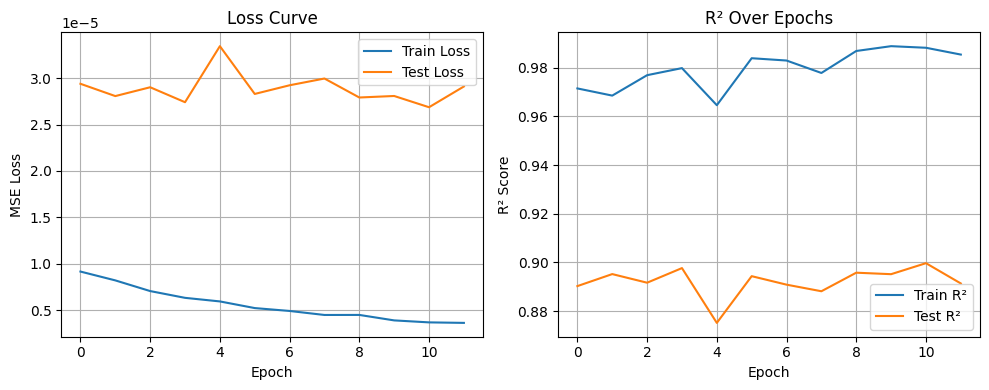

In [9]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_r2s, label='Train R²')
plt.plot(test_r2s, label='Test R²')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.title('R² Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [17]:
import torch
import psutil
import os
import matplotlib.pyplot as plt
import time

process = psutil.Process(os.getpid())

train_losses, test_losses = [], []
train_r2s, test_r2s = [], []
gpu_memories, cpu_memories, cpu_usages = [], [], []
epoch_times = []

n_epochs = 12


In [18]:
for epoch in range(n_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    
    # Validation
    model.eval()
    with torch.no_grad():
        test_loss = criterion(model(X_test), y_test).item()
        train_pred = model(X_train)
        test_pred = model(X_test)
        train_r2 = 1 - ((y_train - train_pred)**2).mean() / ((y_train - y_train.mean())**2).mean()
        test_r2 = 1 - ((y_test - test_pred)**2).mean() / ((y_test - y_test.mean())**2).mean()

    # Record metrics
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_r2s.append(train_r2.item())
    test_r2s.append(test_r2.item())
    epoch_times.append(time.time() - start_time)

    # Resource tracking
    if torch.cuda.is_available():
        current_device = torch.cuda.current_device()
        gpu_mem = torch.cuda.memory_allocated(current_device) / (1024**2)  # MB
    else:
        gpu_mem = float('nan')

    cpu_mem = process.memory_info().rss / (1024**2)  # MB
    cpu_usage = psutil.cpu_percent(interval=None)  # %
    
    gpu_memories.append(gpu_mem)
    cpu_memories.append(cpu_mem)
    cpu_usages.append(cpu_usage)

    print(f"Epoch {epoch+1}/{n_epochs} | Loss: {train_loss:.5f}/{test_loss:.5f} | R²: {train_r2:.3f}/{test_r2:.3f}")
    print(f"  CPU: {cpu_mem:.1f} MB ({cpu_usage:.1f}%) | GPU: {gpu_mem:.1f} MB")


Epoch 1/12 | Loss: 0.00000/0.00003 | R²: 0.994/0.899
  CPU: 8497.9 MB (6.4%) | GPU: nan MB
Epoch 2/12 | Loss: 0.00000/0.00003 | R²: 0.995/0.898
  CPU: 8505.2 MB (24.6%) | GPU: nan MB
Epoch 3/12 | Loss: 0.00000/0.00003 | R²: 0.992/0.894
  CPU: 8505.2 MB (23.6%) | GPU: nan MB
Epoch 4/12 | Loss: 0.00000/0.00003 | R²: 0.990/0.894
  CPU: 8505.2 MB (24.7%) | GPU: nan MB
Epoch 5/12 | Loss: 0.00000/0.00003 | R²: 0.994/0.900
  CPU: 8508.3 MB (24.7%) | GPU: nan MB
Epoch 6/12 | Loss: 0.00000/0.00003 | R²: 0.994/0.896
  CPU: 8508.3 MB (23.8%) | GPU: nan MB
Epoch 7/12 | Loss: 0.00000/0.00003 | R²: 0.996/0.900
  CPU: 8508.3 MB (23.3%) | GPU: nan MB
Epoch 8/12 | Loss: 0.00000/0.00003 | R²: 0.993/0.901
  CPU: 8509.0 MB (23.1%) | GPU: nan MB
Epoch 9/12 | Loss: 0.00000/0.00003 | R²: 0.995/0.897
  CPU: 8510.4 MB (23.4%) | GPU: nan MB
Epoch 10/12 | Loss: 0.00000/0.00003 | R²: 0.995/0.902
  CPU: 8510.4 MB (23.4%) | GPU: nan MB
Epoch 11/12 | Loss: 0.00000/0.00003 | R²: 0.996/0.900
  CPU: 8510.4 MB (23.5%) |

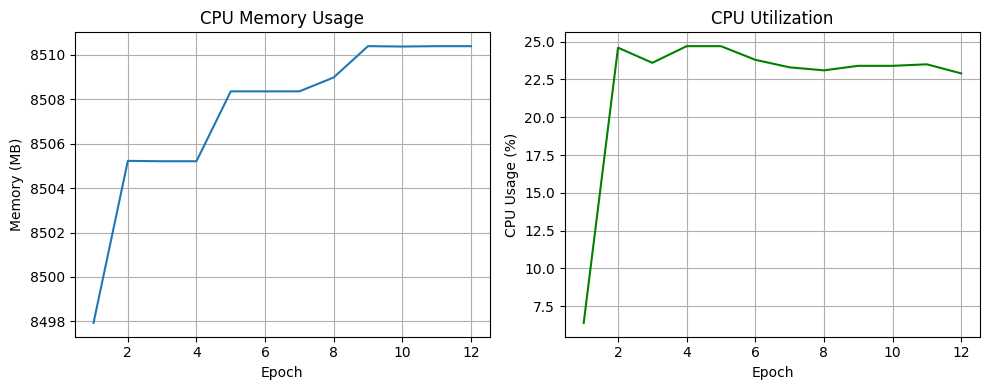

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(range(1, n_epochs+1), cpu_memories, label='CPU Memory (MB)')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Memory (MB)')
ax[0].set_title('CPU Memory Usage')
ax[0].grid(True)

ax[1].plot(range(1, n_epochs+1), cpu_usages, color='green', label='CPU Utilization (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('CPU Usage (%)')
ax[1].set_title('CPU Utilization')
ax[1].grid(True)

plt.tight_layout()
plt.show()

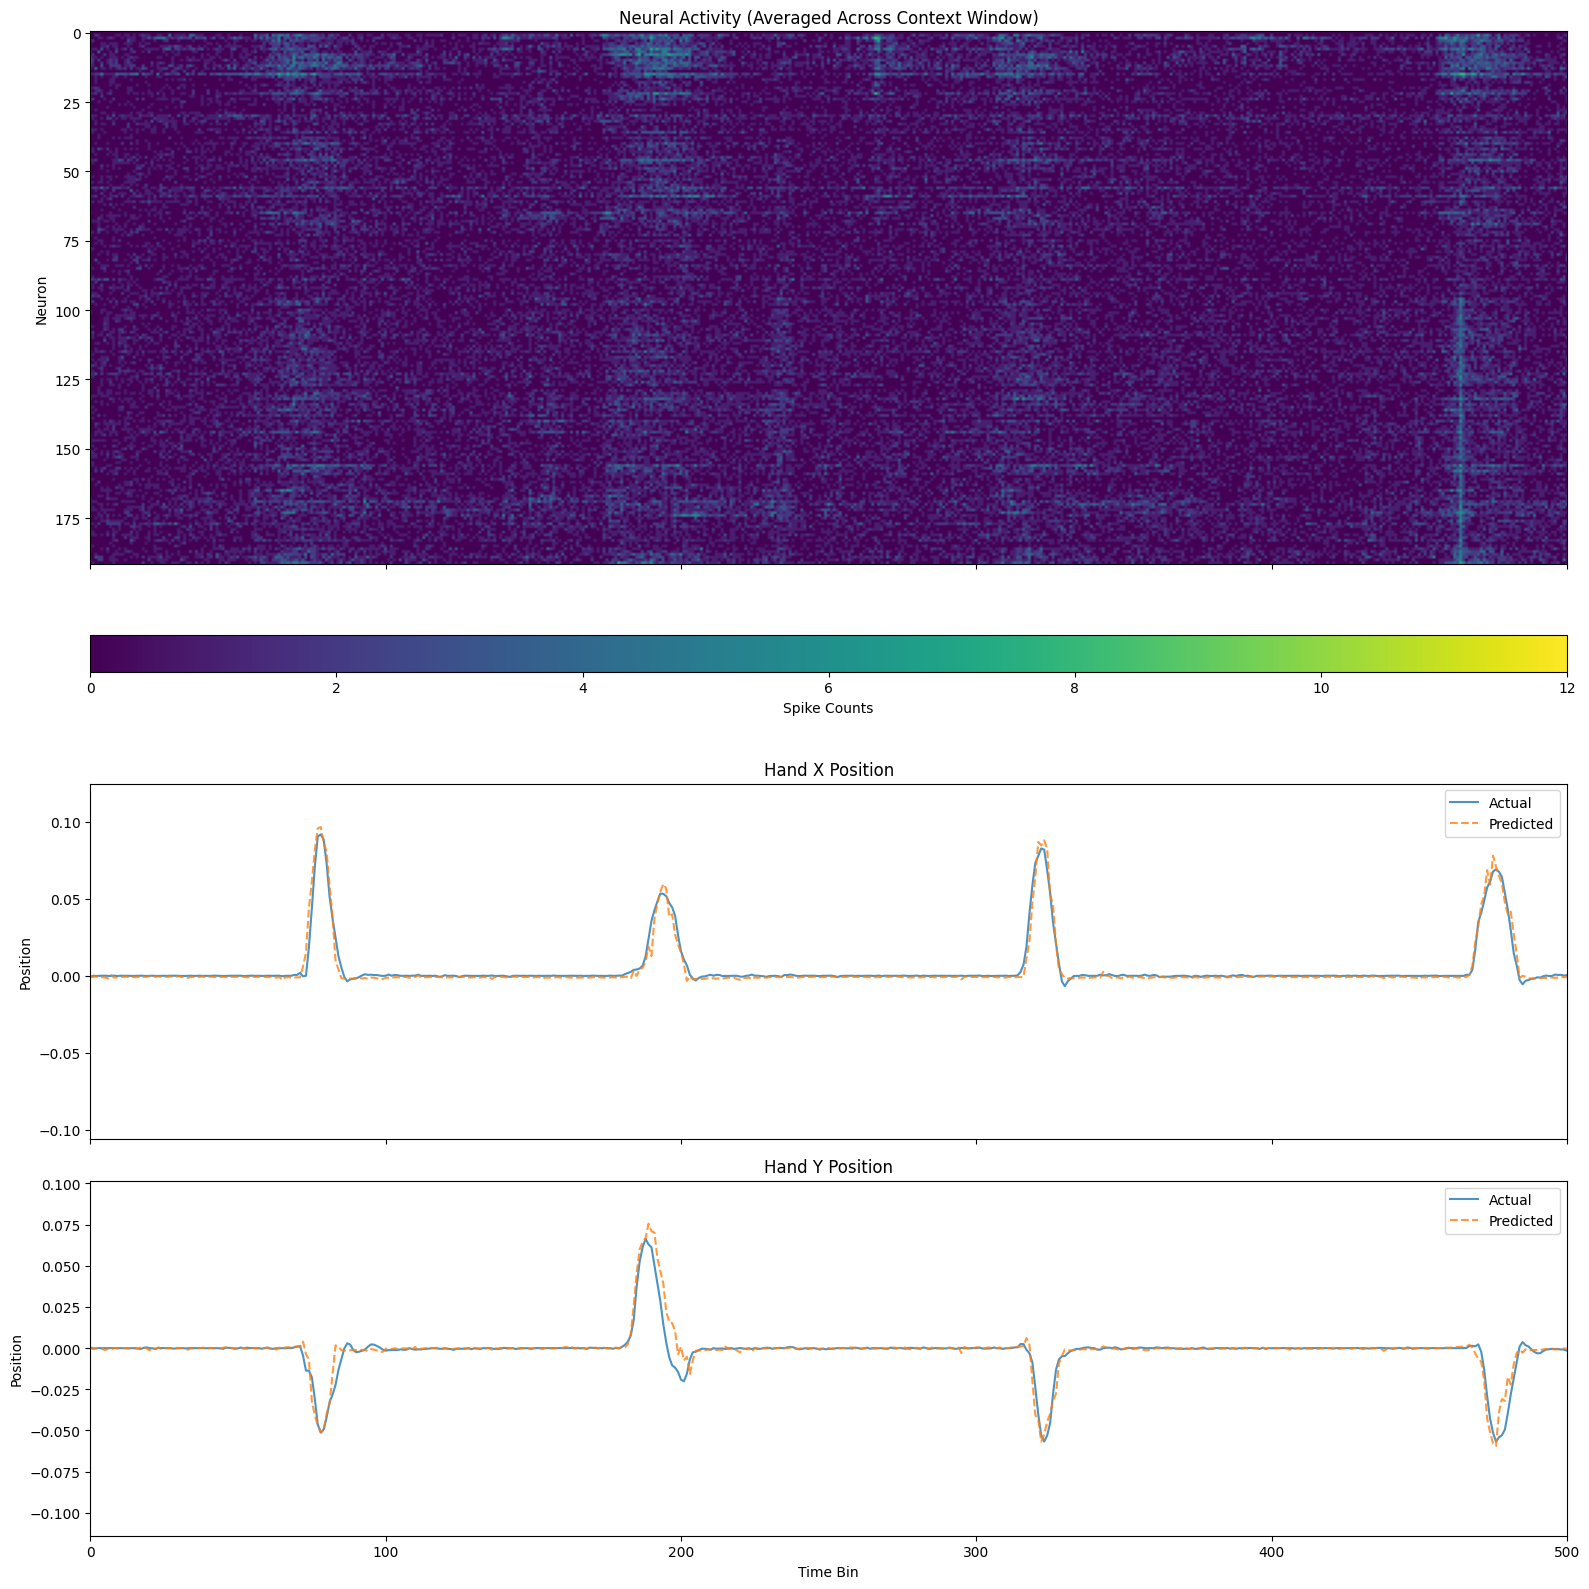

In [5]:
with torch.no_grad():
    test_pred = model(X_test).cpu().numpy()

# Convert dataset to numpy arrays and visualize
import matplotlib.pyplot as plt

# Create figure with subplots and shared x-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 16), height_ratios=[2, 1, 1], sharex=True)

# Plot heatmap of X
im = ax1.imshow(X_test.reshape(-1, n_neurons, n_context_bins)[:, :, -1].T, aspect='auto', cmap='viridis')
ax1.set_title('Neural Activity (Averaged Across Context Window)')
ax1.set_ylabel('Neuron')
# Add smaller colorbar at the top
cbar = plt.colorbar(im, ax=ax1, orientation='horizontal', pad=0.1, aspect=40, label='Spike Counts')

# Plot x coordinate
ax2.plot(y_test[:, 0], label='Actual', alpha=0.8)
ax2.plot(test_pred[:, 0], label='Predicted', alpha=0.8, linestyle='--')
ax2.set_title('Hand X Position')
ax2.set_ylabel('Position')
ax2.legend()

# Plot y coordinate
ax3.plot(y_test[:, 1], label='Actual', alpha=0.8)
ax3.plot(test_pred[:, 1], label='Predicted', alpha=0.8, linestyle='--')
ax3.set_title('Hand Y Position')
ax3.set_xlabel('Time Bin')
ax3.set_ylabel('Position')
ax3.legend()

limit_time_bins = 500
ax1.set_xlim(0, limit_time_bins)
ax2.set_xlim(0, limit_time_bins)
ax3.set_xlim(0, limit_time_bins)

plt.tight_layout()
plt.show()


In [9]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'decoder_mlp.pth')


In [ ]:
import pygame
import numpy as np
import time

# Initialize Pygame
pygame.init()

# Set up display
WIDTH = 1200
HEIGHT = 800
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Neural Spike Train Visualization")

# Colors
BLACK = (0, 0, 0)
GRAY = (40, 40, 40)  # For grid lines
WHITE = (255, 255, 255)

# Get spike data
spike_data = X_test.reshape(-1, n_neurons, n_context_bins)[:, :, -1].T
total_bins = spike_data.shape[1]
window_size = 100

# Calculate scaling factors
neuron_height = HEIGHT // n_neurons
time_bin_width = WIDTH // window_size

# Normalize spike data for color intensity
spike_data_normalized = (spike_data - spike_data.min()) / (spike_data.max() - spike_data.min())

# Create font for labels
font = pygame.font.Font(None, 36)

running = True
current_bin = 0
clock = pygame.time.Clock()

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
            
    # Clear screen
    screen.fill(BLACK)
    
    # Draw grid lines
    for i in range(0, HEIGHT, neuron_height * 200):  # Draw every 200 channels
        pygame.draw.line(screen, GRAY, (0, i), (WIDTH, i), 1)
        # Draw channel number
        label = font.render(str(i // neuron_height), True, WHITE)
        screen.blit(label, (10, i))
    
    # Draw spike trains
    if current_bin + window_size <= total_bins:
        for neuron in range(n_neurons):
            for t in range(window_size):
                intensity = int(spike_data_normalized[neuron, current_bin + t] * 255)
                color = (intensity, intensity, intensity)  # White/gray scale
                if intensity > 0:  # Only draw if there's activity
                    pygame.draw.rect(screen, color,
                                   (t * time_bin_width, neuron * neuron_height,
                                    time_bin_width, neuron_height))
    
    # Draw axis labels
    time_label = font.render("Time", True, WHITE)
    channels_label = font.render("Channels", True, WHITE)
    screen.blit(time_label, (WIDTH // 2 - 30, HEIGHT - 30))
    # Rotate and draw y-axis label
    channels_surface = pygame.Surface((200, 30))
    channels_surface.fill(BLACK)
    channels_surface.blit(channels_label, (0, 0))
    channels_surface = pygame.transform.rotate(channels_surface, 90)
    screen.blit(channels_surface, (10, HEIGHT // 2 - 100))
    
    # Update display
    pygame.display.flip()
    
    # Move window
    current_bin += 1
    if current_bin + window_size > total_bins:
        current_bin = 0
        
    # Control frame rate
    clock.tick(20)  # 30 FPS

pygame.quit()


/opt/miniconda3/envs/jenkins_env/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


pygame 2.6.1 (SDL 2.28.4, Python 3.11.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


: 

In [ ]:
import pygame
import numpy as np
import time

# Initialize Pygame
pygame.init()

# Set up display
WIDTH = 1200
HEIGHT = 1200  # Increased height to accommodate velocity plots
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Neural Spike Train and Velocity Visualization")

# Colors
BLACK = (0, 0, 0)
GRAY = (40, 40, 40)  # For grid lines
WHITE = (255, 255, 255)
RED = (255, 0, 0)    # For predicted velocity
BLUE = (0, 0, 255)   # For actual velocity

# Get spike data
spike_data = X_test.reshape(-1, n_neurons, n_context_bins)[:, :, -1].T
total_bins = spike_data.shape[1]
window_size = 100

# Calculate scaling factors
spike_view_height = HEIGHT // 2  # Top half for spike trains
neuron_height = spike_view_height // n_neurons
time_bin_width = WIDTH // window_size

# Normalize spike data for color intensity
spike_data_normalized = (spike_data - spike_data.min()) / (spike_data.max() - spike_data.min())

# Get velocity data
y_true = y_test
y_pred = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()

def normalize_for_plot(data, plot_height):
    data_min = data.min()
    data_max = data.max()
    denom = data_max - data_min

    # Handle the edge case where all values are equal or data is empty
    if denom == 0 or np.isnan(denom):
        return np.zeros_like(data)  # or data * 0

    return (data - data_min) / denom * plot_height

# Create font for labels
font = pygame.font.Font(None, 36)

running = True
current_bin = 0
clock = pygame.time.Clock()

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
            
    # Clear screen
    screen.fill(BLACK)
    
    # Draw grid lines for spike trains
    for i in range(0, spike_view_height, neuron_height * 200):  # Draw every 200 channels
        pygame.draw.line(screen, GRAY, (0, i), (WIDTH, i), 1)
        # Draw channel number
        label = font.render(str(i // neuron_height), True, WHITE)
        screen.blit(label, (10, i))
    
    # Draw spike trains
    if current_bin + window_size <= total_bins:
        for neuron in range(n_neurons):
            for t in range(window_size):
                intensity = int(spike_data_normalized[neuron, current_bin + t] * 255)
                color = (intensity, intensity, intensity)  # White/gray scale
                if intensity > 0:  # Only draw if there's activity
                    pygame.draw.rect(screen, color,
                                   (t * time_bin_width, neuron * neuron_height,
                                    time_bin_width, neuron_height))
    
    # Draw velocity plots
    plot_height = HEIGHT // 4  # Height for each velocity plot
    y_offset = spike_view_height  # Start below spike trains
    
    # Draw X velocity
    for t in range(window_size - 1):
        if current_bin + t + 1 < len(y_true):
            # True X velocity
            start_y = y_offset + normalize_for_plot(y_true[current_bin + t, 0], plot_height)
            end_y = y_offset + normalize_for_plot(y_true[current_bin + t + 1, 0], plot_height)
            start_pos = (int(t * time_bin_width), int(start_y))
            end_pos = (int((t + 1) * time_bin_width), int(end_y))
            pygame.draw.line(screen, BLUE, start_pos, end_pos, 2)
            
            # Predicted X velocity
            start_y = y_offset + normalize_for_plot(y_pred[current_bin + t, 0], plot_height)
            end_y = y_offset + normalize_for_plot(y_pred[current_bin + t + 1, 0], plot_height)
            start_pos = (int(t * time_bin_width), int(start_y))
            end_pos = (int((t + 1) * time_bin_width), int(end_y))
            pygame.draw.line(screen, RED, start_pos, end_pos, 2)
    
    # Draw Y velocity
    y_offset = spike_view_height + plot_height  # Start below X velocity plot
    for t in range(window_size - 1):
        if current_bin + t + 1 < len(y_true):
            # True Y velocity
            start_y = y_offset + normalize_for_plot(y_true[current_bin + t, 1], plot_height)
            end_y = y_offset + normalize_for_plot(y_true[current_bin + t + 1, 1], plot_height)
            start_pos = (int(t * time_bin_width), int(start_y))
            end_pos = (int((t + 1) * time_bin_width), int(end_y))
            pygame.draw.line(screen, BLUE, start_pos, end_pos, 2)
            
            # Predicted Y velocity
            start_y = y_offset + normalize_for_plot(y_pred[current_bin + t, 1], plot_height)
            end_y = y_offset + normalize_for_plot(y_pred[current_bin + t + 1, 1], plot_height)
            start_pos = (int(t * time_bin_width), int(start_y))
            end_pos = (int((t + 1) * time_bin_width), int(end_y))
            pygame.draw.line(screen, RED, start_pos, end_pos, 2)
    
    # Draw axis labels
    time_label = font.render("Time", True, WHITE)
    channels_label = font.render("Channels", True, WHITE)
    x_vel_label = font.render("X Velocity (Blue: True, Red: Predicted)", True, WHITE)
    y_vel_label = font.render("Y Velocity (Blue: True, Red: Predicted)", True, WHITE)
    
    screen.blit(time_label, (WIDTH // 2 - 30, HEIGHT - 30))
    screen.blit(x_vel_label, (WIDTH // 2 - 150, spike_view_height + 10))
    screen.blit(y_vel_label, (WIDTH // 2 - 150, spike_view_height + plot_height + 10))
    
    # Rotate and draw y-axis label for spike trains
    channels_surface = pygame.Surface((200, 30))
    channels_surface.fill(BLACK)
    channels_surface.blit(channels_label, (0, 0))
    channels_surface = pygame.transform.rotate(channels_surface, 90)
    screen.blit(channels_surface, (10, spike_view_height // 2 - 100))
    
    # Update display
    pygame.display.flip()
    
    # Move window
    current_bin += 1
    if current_bin + window_size > total_bins:
        current_bin = 0
        
    # Control frame rate
    clock.tick(20)  # 30 FPS

pygame.quit()
